In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

from flygym import Fly, Camera, SingleFlySimulation

from flygym.arena import FlatTerrain, MixedTerrain
from flygym.preprogrammed import all_leg_dofs

from arena import ObstacleOdorArena
from flygym.examples.common import PreprogrammedSteps

In [2]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs
preprogrammed_steps = PreprogrammedSteps()
joint_angles = np.concatenate([preprogrammed_steps.get_joint_angles(leg, 0) for leg in ["LF", "LM", "LH", "RF", "RM", "RH"] ])

In [3]:
def sample_visual_data(
    sim, obstacle_positions, action, visualize=False, camera="birdeye_cam"
):
    fly = sim.fly
    # Change obstacle positions in the arena
    for i in range(obstacle_positions.shape[0]):
        pos_xyz = np.array([*obstacle_positions[i, :], sim.arena.obstacle_z_pos])
        sim.physics.bind(sim.arena.obstacle_bodies[i]).mocap_pos = pos_xyz
        sim.step(action)

    # Render visual input
    fly._last_vision_update_time = -np.inf  # hack: this forces visual input update
    fly._update_vision(sim)
    visual_input = fly._curr_visual_input.copy()
    raw_cam_imgs = fly._curr_raw_visual_input.copy()

    # Calculate obstacle positions relative to the fly
    fly_rotation = fly.spawn_orientation[2]
    rot_matrix = np.array(
        [
            [np.cos(fly_rotation), -np.sin(fly_rotation)],
            [np.sin(fly_rotation), np.cos(fly_rotation)],
        ]
    )
    obstacle_positions_transformed = obstacle_positions - fly.spawn_pos[:2]
    obstacle_positions_transformed[:, 1] *= -1  # change y to right-hand-positive
    obstacle_positions_transformed = (rot_matrix @ obstacle_positions_transformed.T).T

    # Visualize
    if visualize:
        fig, axs = plt.subplots(1, 5, figsize=(10, 5), tight_layout=True)
        birdeye_img = sim.physics.render(camera_id=camera, height=512, width=512)
        axs[0].imshow(birdeye_img)
        axs[0].axis("off")
        for i in range(2):
            axs[i + 1].imshow(raw_cam_imgs[i], cmap="gray", vmin=0, vmax=255)
            axs[i + 1].axis("off")
        for i in range(2):
            vis = fly.retina.hex_pxls_to_human_readable(
                visual_input[i].max(-1), color_8bit=True
            )
            axs[i + 3].imshow(vis, cmap="gray", vmin=0, vmax=255)
            axs[i + 3].axis("off")

    return visual_input, obstacle_positions_transformed

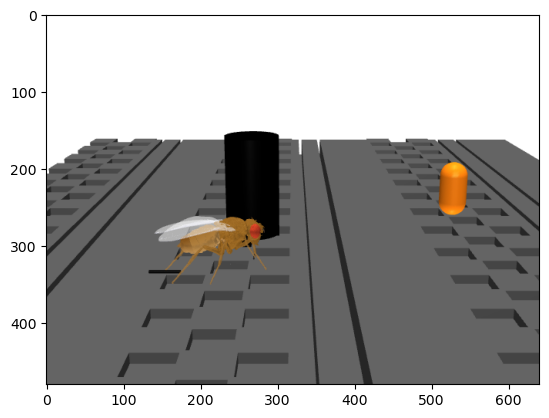

In [4]:
terrain_arena = MixedTerrain(
    height_range=(0.3, 0.3), gap_width=0.2, ground_alpha=1, scale_bar_pos=(5, -4.7, 0.2)
)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0)]),
    obstacle_radius=1,
    odor_source=np.array([[15, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0, 0, 0, 1),
    user_camera_settings=((9, -25, 8), (np.deg2rad(75), 0, 0), 30),
)
fly = Fly(
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
    spawn_pos=(7, -4, 0.5),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(20)),
)
cam = Camera(
    fly=fly,
    camera_id="user_cam",
    play_speed=0.2,
    play_speed_text=False,
)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    arena=arena,
)
action = {"joints": joint_angles}
for i in range(100):
    sim.step(action)
    sim.render()

plt.imshow(cam._frames[-1])
imageio.imsave("outputs/env_overview.png", cam._frames[-1])

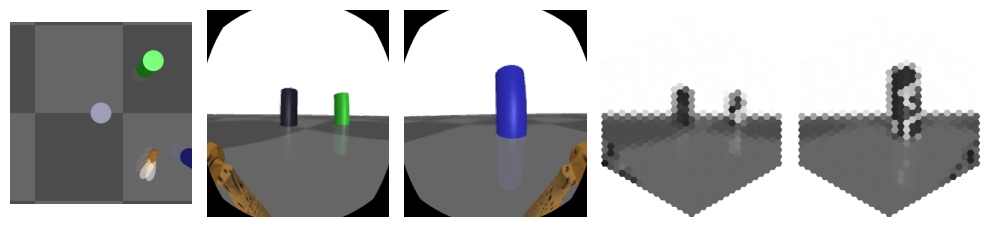

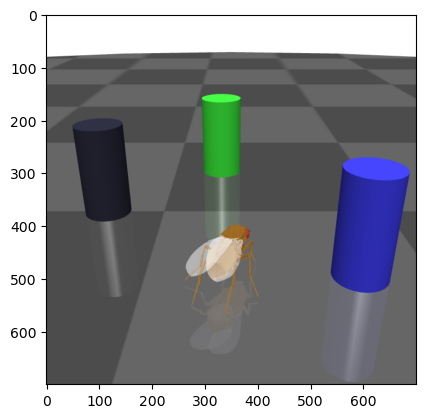

In [5]:
terrain_arena = FlatTerrain()
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)
cam = Camera(
    fly=fly,
    camera_id="user_cam",
    play_speed=0.2,
)
fly = Fly(
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
    spawn_pos=(13, -5, 0.5),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(70)),
)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    arena=arena,
)
action = {"joints": joint_angles}
for i in range(100):
    sim.step(action)
    sim.render()

sample_visual_data(
    sim, np.array([(7.5, 0), (12.5, 5), (17.5, -5)]), action, visualize=True
)
plt.savefig("outputs/vision_sim.pdf", transparent=True)
plt.show()

env_viz = sim.physics.render(camera_id="user_cam", height=700, width=700)

plt.imshow(env_viz)
imageio.imsave("outputs/behind_fly_view.png", env_viz)